# 1. Describe the data
- It has 56 observations.
- There are 3 variables:
    - Insul: A categorical variable indicating whether cavity wall insulation was installed (Before or After).
    - Temp: Average weekly temperature in degrees Celsius.
    - Gas: Weekly natural gas consumption in thousands of cubic feet.
- An English homeowner tracked his weekly natural gas usage (in thousands of cubic feet) over two winter seasons. During the second season, he installed cavity wall insulation. He also recorded the average weekly temperature in degrees Celsius, as it impacts gas consumption.

# 2. Load packages and data

In [1]:
%%capture
pip install faraway

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import faraway.utils

In [3]:
import faraway.datasets.whiteside
whiteside = faraway.datasets.whiteside.load()
whiteside.head()

,Insul,Temp,Gas
1,Before,-0.8,7.2
2,Before,-0.7,6.9
3,Before,0.4,6.4
4,Before,2.5,6.0
5,Before,2.9,5.8


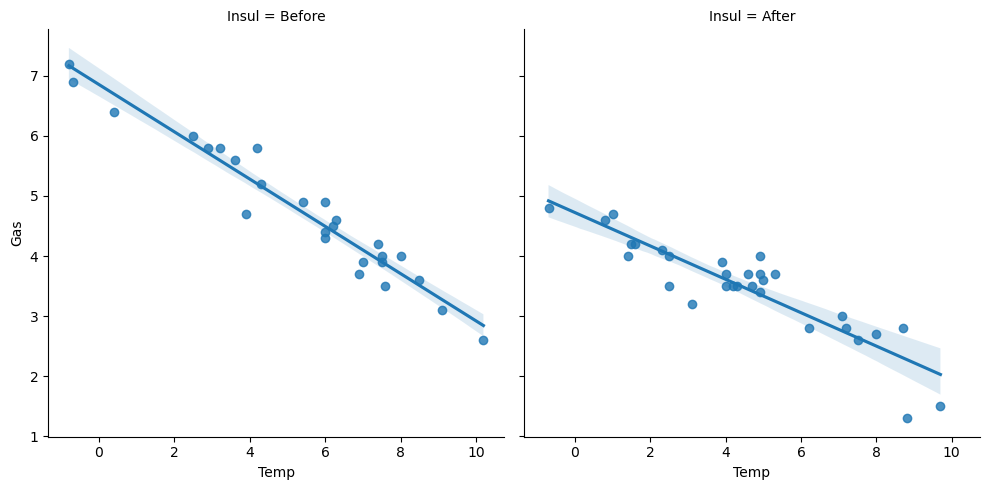

In [7]:
sns.lmplot(x="Temp", y="Gas", col="Insul", data=whiteside);

- We can see that less gas is used after the insulation is installed, but the difference varies by temperature. The relationships appear linear. 
- Before fitting a model, set the reference level for Insul. By default, it's "After" (alphabetically first), but "Before" is more intuitive for comparison. This can be done conveniently with:

In [8]:
whiteside['Insul'] = pd.Categorical(whiteside['Insul'],
                         categories=['Before','After'])
whiteside['Insul'].dtype

CategoricalDtype(categories=['Before', 'After'], ordered=False, categories_dtype=object)

- This creates a categorical variable with “Before” as the first level. This order will be used when fitting the models.

In [9]:
lmod = smf.ols('Gas ~ Temp*Insul', whiteside).fit()
lmod.sumary()

                     coefs stderr tvalues pvalues
Intercept            6.854  0.136   50.41  0.0000
Insul[T.After]      -2.130  0.180  -11.83  0.0000
Temp                -0.393  0.022  -17.49  0.0000
Temp:Insul[T.After]  0.115  0.032    3.59  0.0007

n=56 p=4 Residual SD=0.323 R-squared=0.93


- We predict that gas consumption decreases by 0.393 for each 1°C increase in temperature before insulation. After insulation, the decrease per degree is only 0.278 (0.393 - 0.115).
- The other two parameter estimates represent predicted consumption when the temperature is zero. Before insulation, gas consumption at this temperature is 6.854, and after insulation, it is 4.724 (6.854 - 2.130).
- This temperature is at the lower edge of the observed range and may not represent a typical difference. In other datasets, a continuous predictor value of zero might be far outside the range, making these parameters less meaningful. The solution is to center the temperature predictor by its mean value and recompute the linear model:

In [10]:
whiteside.Temp.mean()

4.875

In [11]:
whiteside['cTemp'] = whiteside.Temp - whiteside.Temp.mean()
lmod = smf.ols('Gas ~ cTemp*Insul', whiteside).fit()
lmod.sumary()

                      coefs stderr tvalues pvalues
Intercept             4.937  0.064   76.85  0.0000
Insul[T.After]       -1.568  0.088  -17.87  0.0000
cTemp                -0.393  0.022  -17.49  0.0000
cTemp:Insul[T.After]  0.115  0.032    3.59  0.0007

n=56 p=4 Residual SD=0.323 R-squared=0.93


- Now we can say that the average gas consumption before insulation at the average temperature was 4.94, and it dropped to 3.37 (4.94 - 1.57) after insulation. The other two coefficients remain unchanged, and their interpretation is the same. This shows that centering allows for a more typical interpretation of the parameter estimates when there is interaction.
- We wouldn't expect insulation to have a constant absolute effect on fuel use; the benefits are greater at lower temperatures. A significant interaction effect is anticipated. Instead, insulation likely has a relative effect on fuel use, which can be modeled with a log transformation on the response.

In [12]:
lmod = smf.ols('np.log(Gas) ~ Temp*Insul', whiteside).fit()
lmod.sumary()

                     coefs stderr tvalues pvalues
Intercept            1.968  0.054   36.46  0.0000
Insul[T.After]      -0.340  0.072   -4.75  0.0000
Temp                -0.082  0.009   -9.20  0.0000
Temp:Insul[T.After] -0.011  0.013   -0.85  0.3983

n=56 p=4 Residual SD=0.128 R-squared=0.84


- Now the interaction term is not significant and can be removed:

In [13]:
lmod = smf.ols('np.log(Gas) ~ Temp+Insul', whiteside).fit()
lmod.sumary()

                coefs stderr tvalues pvalues
Intercept       1.997  0.042   47.24  0.0000
Insul[T.After] -0.393  0.035  -11.31  0.0000
Temp           -0.087  0.006  -13.75  0.0000

n=56 p=3 Residual SD=0.128 R-squared=0.84


- The model states that:
$$ \log Gas =  β_0 + β_{Insul} + β_{Temp}Temp $$
$$ Gas = e^{β_0} e^{β_{Insul}} e^{β_{Temp}Temp} $$
- Hence the effect of the insulation is to multiply the response by $e^{-0.393} = 0.675$. In simple terms, the analysis shows that insulation reduces gas consumption by 32.5%.